# XGBOOST implementation in exchange rate dataset

## 1. Load all requirements

In [1]:
# download repo
! git clone -b data_folder https://github.com/MarthyGarcia/IFT6759_B_H23.git
%cd IFT6759_B_H23

# install make
! apt-get install binutils

# run dependencies
! make requirements
! make sync_data

Cloning into 'IFT6759_B_H23'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 320 (delta 56), reused 48 (delta 38), pack-reused 233
Receiving objects: 100% (320/320), 5.19 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (180/180), done.
/content/IFT6759_B_H23
Reading package lists... Done
Building dependency tree       
Reading state information... Done
binutils is already the newest version (2.34-6ubuntu1.4).
binutils set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
python3 test_environment.py
>>> Development environment passes all tests!
python3 -m pip install -U pip setuptools wheel
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
python3 -m pip install -r requirements.txt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///cont

In [4]:
from darts.metrics import mae
from src.pipeline.pipeline import ExperimentPipeline
from darts.models import TransformerModel, ExponentialSmoothing, XGBModel
from src.pipeline.experiment import Experiment, HyperParameter, BayesOptHyperParameter
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.utils.utils import ModelMode
from pytorch_lightning.callbacks import EarlyStopping

We first define our dataset and algorithm

In [25]:
# define dataset
dataset = 'exchange_rate'  # ['exchange_rate', 'traffic', 'electricity'], only uses first covariate

In [26]:
# set DARTS model class
model =  XGBModel

In [27]:
# define preprocessing
preprocessing = Pipeline([
    Scaler()
])

The we define our hyperparameters, which can either be set as `HyperParameters` or sampled from a distribution with `BayesOptHyperparameter`

for more info on which method are available, see documentation [here](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html)

In [32]:
hparams  = [

    HyperParameter(
        name='lags',
        value=90
    ),

    HyperParameter(
        name='output_chunk_length',
        value=90
    )

]




Once this is done we can define our experiment

In [33]:
params = Experiment(
    dataset=dataset,
    preprocessing=preprocessing,
    model=model,
    hyper_parameters=hparams,
    metric=mae,
    horizon=90,           # Horizon for prediction
    optuna_timeout=120,   # Time allocated for HParam search in seconds
    n_backtest=100,           # Number of validation samples for the backtest, means len(valid_dataset)
    n_train_samples=500     # Number of samples for our .fit(), means len(train_dataset)
)

The we run the experiment and save the logs in our ipynb

In [34]:
# get loads of warnings
import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [35]:
pipeline = ExperimentPipeline(params)
pipeline.run()

Fetching Data ...
Beginning Optimization


100%|██████████| 102/102 [00:07<00:00, 13.20it/s]


value: 0.1587760926686764


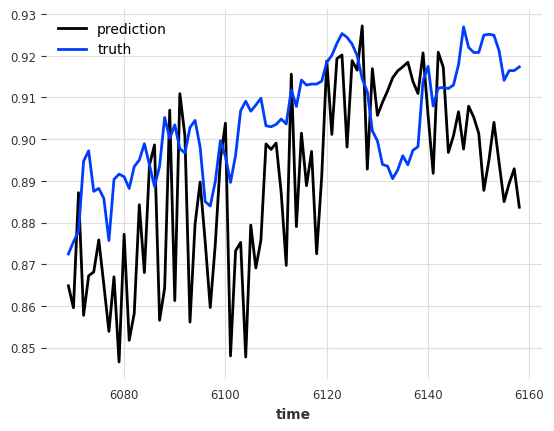

In [36]:
#Best value: 0.1587760926686764
series = pipeline.data['train'].append(pipeline.data['valid'])
model = XGBModel(
    lags=90,
    output_chunk_length=90,
    random_state=0
)

model.fit(series)

preds = model.predict(n=90)
preds.plot(label='prediction')

pipeline.data['test'][:90].plot(label='truth')

In [37]:
# evaluate with full backtest on test data--0.06670899968518283
from darts.models.forecasting.forecasting_model import LocalForecastingModel

model.backtest(
    series=series.append(pipeline.data['test']) + 1e-9,
    start=len(series),
    forecast_horizon=90,
    retrain=isinstance(model, LocalForecastingModel),
    metric=mae,
)




0.06670899968518283